In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
from sklearn.metrics import mean_squared_error
import pandas_datareader as dr


In [2]:
%run PrepareData.ipynb

,high_value,low_value,open_value,close_value,volume,Adj Close
Date,,,,,,
2015-01-02,14.883333,14.217333,14.858000,14.620667,71466000,14.620667
2015-01-05,14.433333,13.810667,14.303333,14.006000,80527500,14.006000
2015-01-06,14.280000,13.614000,14.004000,14.085333,93928500,14.085333
2015-01-07,14.318667,13.985333,14.223333,14.063333,44526000,14.063333
2015-01-08,14.253333,14.000667,14.187333,14.041333,51637500,14.041333


,high_value,low_value,open_value,close_value,volume,Adj Close
Date,,,,,,
2020-05-22,55.452000,54.133331,54.811333,54.458668,149812500,54.458668
2020-05-26,55.639999,54.380669,55.633331,54.591331,121345500,54.591331
2020-05-27,55.180668,52.333332,54.723999,54.681999,173242500,54.681999
2020-05-28,54.983334,53.445999,54.234001,53.720669,108834000,53.720669
2020-05-29,55.666668,53.613998,53.916668,55.666668,176467500,55.666668


Stored 'tsla_tweets_df' (DataFrame)
Stored 'tsla_stock_values_df' (DataFrame)
Stored 'ta_df' (DataFrame)
Stored 'tsla_sentiments_df' (DataFrame)
Stored 'tsla_sentiments_df_textblob' (DataFrame)


In [3]:
# tsla_stock_values_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1361 entries, 2015-01-02 to 2020-05-29
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   high_value   1361 non-null   float64
 1   low_value    1361 non-null   float64
 2   open_value   1361 non-null   float64
 3   close_value  1361 non-null   float64
 4   volume       1361 non-null   int64  
 5   Adj Close    1361 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 74.4 KB


In [5]:
tsla_feature_df = tsla_stock_values_df["close_value"]
# tsla_feature_df.info()

<AxesSubplot:xlabel='Date'>

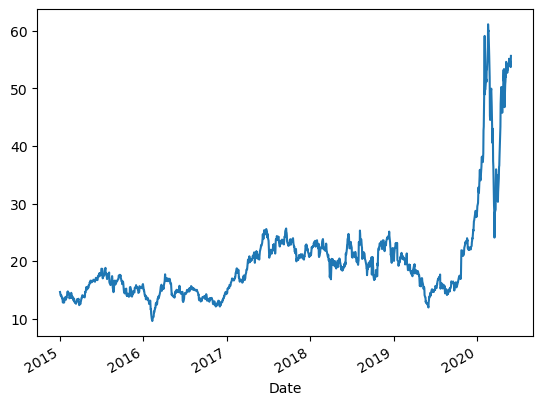

In [6]:
tsla_feature_df.plot()

In [7]:
minmax_scaler = MinMaxScaler(feature_range = (0,1))
tsla_feature_df = minmax_scaler.fit_transform(np.array(tsla_feature_df).reshape(-1,1))

array([[0.09775769],
       [0.08584167],
       [0.08737964],
       ...,
       [0.87439097],
       [0.85575452],
       [0.89347987]])

In [23]:
# This function is used to pre-process the data, where in we are converting data into dependent and independent data based on timestamp
def create_model_dataset(dataset,time_step):
    XData, YData = [],[]    
    # print(len(dataset)-time_step-1)
    for i in range(len(dataset)-time_step-1):
        t = i + time_step
        data = dataset[i : i+time_step,0]
        XData.append(data)        
        YData.append(dataset[i+time_step,0])
    return np.array(XData),np.array(YData)   


In [9]:
train_data_size = int (len(tsla_feature_df) * .7)
test_data_size = len(tsla_feature_df) - train_data_size

train_data, test_data = tsla_feature_df[0:train_data_size,:],tsla_feature_df[train_data_size:len(tsla_feature_df),:1 ]

time_step = 100
X_train, y_train = create_model_dataset(train_data,time_step)
X_test, y_test = create_model_dataset(test_data,time_step)


array([0.19030695, 0.18053636, 0.18777383, 0.18906626, 0.17028756,
       0.16261066, 0.16      , 0.16792246, 0.16846527, 0.1562003 ,
       0.15088855, 0.16038773, 0.16951213, 0.17441035, 0.17601293,
       0.18805818, 0.18379321, 0.19145721, 0.16040064, 0.16968015,
       0.16740549, 0.16625524, 0.17110177, 0.16122779, 0.16029725,
       0.15859129, 0.1676123 , 0.16485947, 0.16748303, 0.15389984,
       0.15538609, 0.14861389, 0.13435865, 0.11821648, 0.12639741,
       0.12280454, 0.11675607, 0.12979644, 0.14392248, 0.14432311,
       0.13362198, 0.13075282, 0.12705655, 0.12387723, 0.10770921,
       0.11455897, 0.1140937 , 0.10941519, 0.08705656, 0.07972861,
       0.07936672, 0.0634055 , 0.06697255, 0.06069144, 0.05819709,
       0.05969629, 0.05757674, 0.05362197, 0.04562196, 0.06452989,
       0.06839418, 0.08049111, 0.07861712, 0.08944751, 0.09490146,
       0.084769  , 0.09077868, 0.09208401, 0.10515024, 0.10477545,
       0.10695961, 0.09815831, 0.10105331, 0.1033538 , 0.09833

In [10]:
# for LSTM we need to reshape our X_train and X_test to be [samples, time steps and batch_size]
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [11]:
# Create LSTM model
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer= 'adam')
model.summary()

Metal device set to: Apple M1


2022-10-09 14:35:59.156779: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-09 14:35:59.158609: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=100,batch_size=64,verbose=1)

Epoch 1/100


2022-10-09 14:36:00.094533: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-09 14:36:01.741021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-09 14:36:02.029280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-09 14:36:02.264192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-09 14:36:02.402621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-09 14:36:02.603183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-09 14:36:02.932261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

14/14 [==============================] - ETA: 0s - loss: 0.0087

2022-10-09 14:36:05.747408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-09 14:36:05.868685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-09 14:36:06.045243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-09 14:36:06.201287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 7s 262ms/step - loss: 0.0087 - val_loss: 0.0582
Epoch 2/100
14/14 [==============================] - 1s 79ms/step - loss: 0.0023 - val_loss: 0.0271
Epoch 3/100
14/14 [==============================] - 1s 75ms/step - loss: 0.0011 - val_loss: 0.0132
Epoch 4/100
14/14 [==============================] - 1s 72ms/step - loss: 7.7077e-04 - val_loss: 0.0119
Epoch 5/100
14/14 [==============================] - 1s 71ms/step - loss: 7.1248e-04 - val_loss: 0.0136
Epoch 6/100
14/14 [==============================] - 1s 71ms/step - loss: 6.6236e-04 - val_loss: 0.0131
Epoch 7/100
14/14 [==============================] - 1s 71ms/step - loss: 6.7107e-04 - val_loss: 0.0122
Epoch 8/100
14/14 [==============================] - 1s 70ms/step - loss: 6.3071e-04 - val_loss: 0.0110
Epoch 9/100
14/14 [==============================] - 1s 81ms/step - loss: 6.1649e-04 - val_loss: 0.0104
Epoch 10/100
14/14 [==============================] - 1s 72ms/step - loss: 5.9978e-04 -

In [13]:
# Prediction
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


2022-10-09 14:37:52.396812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-09 14:37:52.507082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-09 14:37:52.737871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-09 14:37:52.866051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 1s 65ms/step


In [14]:
#Transform predicted data to original form
train_predict = minmax_scaler.inverse_transform(train_predict)
test_predict= minmax_scaler.inverse_transform(test_predict)

In [15]:
# Calculate RMSE for both train and test data
import math
math.sqrt(mean_squared_error(y_train,train_predict))

17.950533092790796

In [16]:
math.sqrt(mean_squared_error(y_test,test_predict))

27.27316252605163

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


851


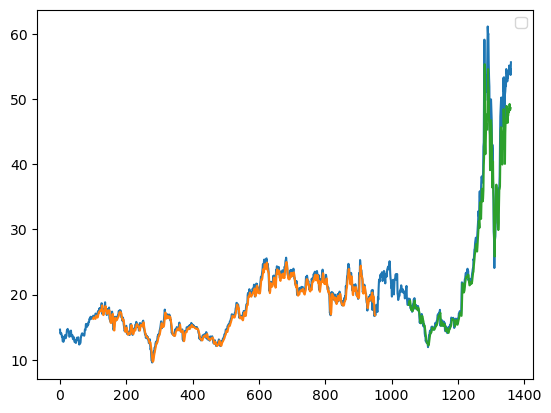

In [17]:
# Plot for comparing actual data with train predictions, test predictons
# as we considers time step of 100, going back 100 days to better visualistion

back_time = 100
print(len(train_predict))
# shift train predictions
# print(minmax_scaler.inverse_transform(tsla_feature_df))
trainpredict_plt = np.empty_like(tsla_feature_df)
trainpredict_plt[:,:] = np.nan
trainpredict_plt[back_time: len(train_predict) + back_time ,: ] = train_predict

# shift test predictions
testpredict_plt = np.empty_like(tsla_feature_df)
testpredict_plt[:,:] = np.nan
testpredict_plt[len(train_predict)+(back_time*2)+1: len(tsla_feature_df)-1,: ] = test_predict

plt.plot(minmax_scaler.inverse_transform(tsla_feature_df))
plt.plot(trainpredict_plt)
plt.plot(testpredict_plt)
plt.legend()
plt.show()

In [18]:
test_data_size = len(test_data)
print(test_data_size)

409


In [19]:
x_input = test_data[test_data_size-time_step:].reshape(1,-1)
x_moving_input = list(x_input)
x_moving_input=x_input[0].tolist()


In [20]:
# predictions for next 30 days
num_days = 30
output_l = []
count = 0
while(count < num_days):
    if(len(x_moving_input) > time_step):
        x_input=np.array(x_moving_input[1:])
        # print("{} day input {}".format(count,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape(1,time_step,1)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day input {}".format(count,yhat))
        x_moving_input.extend(yhat[0].tolist())
        x_moving_input = x_moving_input[1:]
        output_l.extend(yhat.tolist())
    else:
        x_input = x_input.reshape(1,time_step,1)
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        x_moving_input.extend(yhat[0].tolist())        
        # print(len(x_moving_input))
        output_l.extend(yhat.tolist())
        
    count = count +1
    
print(output_l)

[[0.7803387641906738], [0.6597915291786194], [0.5414950847625732], [0.456417053937912], [0.41063597798347473], [0.3996579051017761], [0.41246849298477173], [0.4373141825199127], [0.4650604724884033], [0.4896262586116791], [0.5072823762893677], [0.5162094831466675], [0.5164586901664734], [0.5097848773002625], [0.4989793300628662], [0.48687535524368286], [0.4755159616470337], [0.46580854058265686], [0.45765939354896545], [0.450368732213974], [0.4430660903453827], [0.4350489675998688], [0.42597123980522156], [0.41588321328163147], [0.40515345335006714], [0.39432159066200256], [0.3839356005191803], [0.3744225800037384], [0.3660207688808441], [0.3587740659713745]]


In [21]:
# plot_predicted_value = minmax_scaler.inverse_transform(output_l)
# print(plot_predicted_value)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


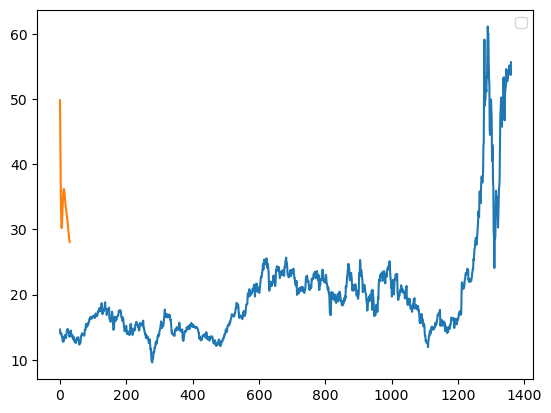

In [22]:
data_source = 'yahoo'
# print(tsla_stock_values_df.index.max())
start_date = tsla_stock_values_df.index.max() + pd.DateOffset(days=1) 
end_date = start_date + pd.DateOffset(days=30) 
# start_date = pd.to_datetime("2015-01-01")
# end_date = pd.to_datetime("2020-05-29")
# start_date + pd.DateOffset(days=30) 

actual_price_30days_df = dr.DataReader("TSLA", data_source, start_date, end_date)
actual_price_30days_df = actual_price_30days_df.rename({"Date": "day_value", "High": "high_value",
                                       "Low":"low_value", "Open":"open_value",
                                       "Close":"close_value",
                                       "Volume":"volume"},axis=1)
# display(actual_price_30days_df.head())
# print(np.array(actual_price_30days_df["Close"]))
plt.plot(minmax_scaler.inverse_transform(tsla_feature_df))
# plt.plot(np.array(actual_price_30days_df["Close"]))
plt.plot(minmax_scaler.inverse_transform(output_l))

# plt.plot(testpredict_plt)
plt.legend()
plt.show()
# actual_price_30days_df.to_csv("Resources/TSLA.csv")